# Module Prep Activity — Agentic RAG (30–45 min)

**Goal:** Build intuition for when to retrieve, what to retrieve, and how a simple agent can decide between answering directly vs. calling a retriever.

---

### What students will do

1.  Learn core terms.
2.  Sketch a tiny agent loop.
3.  Run a toy RAG in Python on a local mini-corpus.
4.  Reflect on trade-offs.

## Part A — Key Concepts in Agentic RAG

Below are six foundational ideas for Retrieval-Augmented Generation.

Read each short description, then answer the reflection prompt at the end.

| Term | Definition / Context |
| :--- | :--- |
| **Retrieval-Augmented Generation (RAG)** | A hybrid AI approach that combines information retrieval (fetching relevant external text) with generation (producing natural-language answers). RAG improves factual accuracy by **grounding** the model’s responses in retrieved data. |
| **Retriever** | A component that searches a corpus for relevant passages. Examples: **BM25** and **TF-IDF** (lexical retrievers based on word overlap) or **embedding-based** retrievers that measure semantic similarity between query and document vectors. |
| **Generator** | The model that takes the retrieved evidence and produces a coherent response. In modern systems this is often an **LLM** that conditions on retrieved context to compose or summarize an answer. |
| **Agentic Control** | The decision-making layer of an agent system—responsible for planning steps, invoking tools (like retrievers), and deciding when to reflect, verify, or stop. It makes RAG agentic rather than a static pipeline. |
| **Grounding / Citations** | The process of linking generated statements back to source material. Grounding builds trust and enables verification by showing where the answer came from. |
| **Hallucination** | When a model outputs information that is not supported—or even contradicted—by its context or training data. Reducing hallucinations is a core motivation for RAG and agentic control. |

---

### Reflection Prompt:

After reading the table, write 3–5 sentences or bullet points addressing the following:

* Which of these components do you think has the **biggest impact on answer quality** in a RAG system and why?
* Can you imagine a situation where adding retrieval might actually **hurt performance or accuracy**?
* How might an agentic controller decide **when not to retrieve**?

**Submission:** One short paragraph or bullet list responding to the reflection prompts.

The component with the biggest impact on answer quality is the retriever, because if the retrieved data is irrelevant, outdated, or noisy, even the best generator cannot produce an accurate grounded answer. High-quality retrieval effectively constrains the model to work with correct evidence.

Retrieval can hurt performance when the query is narrow, creative, or reasoning-heavy—cases where introducing external text distracts the model, introduces noise, or forces it to anchor on irrelevant passages (“retrieval overload”).

An agentic controller might skip retrieval when the query falls into categories like definitions, math or logic, summarizing known context, or when confidence from internal reasoning is high and the cost of retrieval outweighs the benefit. It might also avoid retrieval if previous retrieval attempts repeatedly fail to improve answer quality or if the query matches patterns known to be better handled by pure reasoning.

## Part B — Mini Diagram 

Sketch (hand-drawn or digital) a tiny loop:

$$
\text{User Query} \rightarrow \text{Agent (decide)} \rightarrow [\text{Retrieve? yes/no}]
$$

* **If yes** $\rightarrow$ Top-$k$ Chunks $\rightarrow$ Generator $\rightarrow$ Answer (+sources)
* **If no** $\rightarrow$ Direct Answer $\rightarrow$ (optionally verify)

Label where **confidence**, **$k$**, and **stop conditions** live.

**Submission:** image/PDF of your diagram.

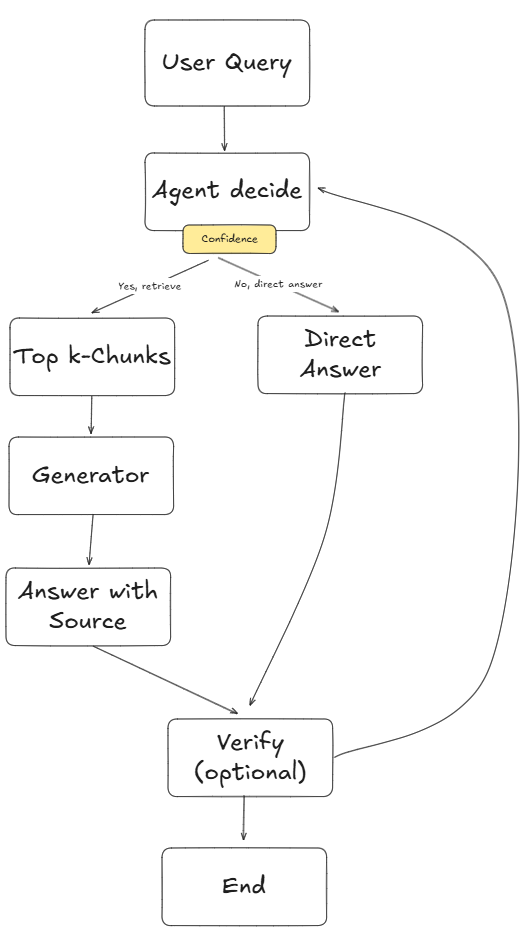

## Part C — Tiny Agentic RAG 

Run the following code. It simulates an “agent” that only calls a TF-IDF retriever when its naive direct answer confidence is low.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np, textwrap

# --- Toy corpus (3–5 short docs) ---
docs = [
    ("doc1", "Vector databases store embeddings for fast similarity search using approximate nearest neighbor methods."),
    ("doc2", "Retrieval-Augmented Generation (RAG) combines a retriever with a generator to ground answers in external knowledge."),
    ("doc3", "BM25 and TF-IDF are classic lexical retrievers; embedding models enable semantic retrieval."),
    ("doc4", "Agentic systems can plan, call tools like retrievers, reflect on answers, and iterate until a stop criterion."),
    ("doc5", "Hallucination occurs when a model asserts unsupported content; citations and verification reduce risk.")
]

ids, corpus = zip(*docs)

# --- Simple TF-IDF retriever ---
tfidf = TfidfVectorizer(stop_words="english").fit(corpus)
doc_mat = tfidf.transform(corpus)

def retrieve(query, k=2):
    q = tfidf.transform([query])
    sims = cosine_similarity(q, doc_mat)[0]
    top_idx = np.argsort(sims)[::-1][:k]
    return [(ids[i], corpus[i], float(sims[i])) for i in top_idx]

# --- Naive "direct answer" confidence (toy heuristic) ---
def direct_answer_confidence(query):
    # Confidence = max TF-IDF cosine to corpus (proxy: how "seen" the topic is)
    q = tfidf.transform([query])
    return float(cosine_similarity(q, doc_mat).max())

# --- Generator (toy): stitch retrieved snippets with mild formatting ---
def generate_answer(query, retrieved):
    context = " ".join(t for _, t, _ in retrieved)
    answer = f"Q: {query}\nA: {textwrap.shorten(context, width=350, placeholder=' …')}"
    sources = ", ".join([i for i,_,_ in retrieved])
    return answer + f"\n\nSources: {sources}"

# --- Agent loop ---
def ask(query, conf_threshold=0.35, k=2):
    conf = direct_answer_confidence(query)
    if conf >= conf_threshold:
        # pretend the model can answer from prior knowledge
        return f"Q: {query}\nA: Based on prior knowledge, this seems straightforward.\n(Confidence={conf:.2f}; no retrieval)"
    else:
        retrieved = retrieve(query, k=k)
        return generate_answer(query, retrieved)

# --- Try it ---
queries = [
    "What is RAG and why use it?",
    "How do vector DBs help in retrieval?",
    "Explain BM25 vs TF-IDF vs embeddings.",
    "How do agentic systems reduce hallucination?"
]

for q in queries:
    print(ask(q, conf_threshold=0.8, k=5))
    print("-" * 80)


Q: What is RAG and why use it?
A: Retrieval-Augmented Generation (RAG) combines a retriever with a generator to ground answers in external knowledge. Hallucination occurs when a model asserts unsupported content; citations and verification reduce risk. Agentic systems can plan, call tools like retrievers, reflect on answers, and iterate until a stop criterion. BM25 and TF-IDF are …

Sources: doc2, doc5, doc4, doc3, doc1
--------------------------------------------------------------------------------
Q: How do vector DBs help in retrieval?
A: Vector databases store embeddings for fast similarity search using approximate nearest neighbor methods. Retrieval-Augmented Generation (RAG) combines a retriever with a generator to ground answers in external knowledge. BM25 and TF-IDF are classic lexical retrievers; embedding models enable semantic retrieval. Hallucination occurs when a model …

Sources: doc1, doc2, doc3, doc5, doc4
----------------------------------------------------------------

### What to modify 

* Change `conf_threshold` and `k` and observe answer length/sources.
* Add one extra document to the corpus and re-run: how do results change?
* Replace the `generate_answer` to bullet the key points and always show sources.

**Submission:** brief notes (3–5 sentences) on what changed and why.

---

## Part D — Reflection 

*Short answers (1–2 sentences each):*

1.  When would agentic control decide not to retrieve?
    When the confidence is higher than the confidence threshold that the agent decided not to retrieve any documents.
2.  One failure mode you observed, and a mitigation (e.g., `re-query`, `increase k`, `verify`).
    When increase k too high, then we are really just showing every single answer. The cutoff of 300 does not seem to be enough here.
3.  A metric you would track in a real system (e.g., `answerable@k`, `citation coverage`, `latency`).
    - **Related**: Can use human or LM as judge
    - **Citation cover**: Use LM-as-judge to break down into individual points, and have confidence score on whether this point was well supported by the document
    - **Latency**: Self-explantory